In [102]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} 
    h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render 
    h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render 
    h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} 
    h4:before{ content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render 
    h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Sydney Liveability Analysis

## Group - 5  F10Adv-01

### Importing Modules

Before we proceed with the analysis, we must first import all the necessary modules required to perform the analysis.

In [103]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

from math import sqrt
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [104]:
sa2_data = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

In [105]:
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

In [106]:
school_catchments_future = gpd.read_file("school_catchments/catchments_future.shp")

In [107]:
school_catchments_primary = gpd.read_file("school_catchments/catchments_primary.shp")

In [108]:
school_catchments_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")

In [109]:
neighbourhoods = pd.read_csv('Neighbourhoods.csv')

In [110]:
BusinessStats = pd.read_csv('BusinessStats.csv')

In [111]:
Playgrounds_json = json.load(open('Playgrounds.geojson'))

Playgrounds_DataFrame = pd.DataFrame(Playgrounds_json["features"])
Playgrounds_pandas_data=[]
for index, row in Playgrounds_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Name"]]
    Playgrounds_pandas_data.append(append_row)
    
Playgrounds = pd.DataFrame(Playgrounds_pandas_data, columns = ['X', 'Y','Name'])
Playgrounds['geom'] = gpd.points_from_xy(Playgrounds.X, Playgrounds.Y)  # creating the geometry column
Playgrounds = Playgrounds.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

In [112]:
Lights_json = json.load(open('Lights.geojson'))
Lights_DataFrame = pd.DataFrame(Lights_json["features"])
Lights_pandas_data=[]
for index, row in Lights_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Location"]]
    Lights_pandas_data.append(append_row)
    
Lights = pd.DataFrame(Lights_pandas_data, columns = ['X', 'Y','Location'])
Lights['geom'] = gpd.points_from_xy(Lights.X, Lights.Y)  # creating the geometry column
Lights = Lights.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

### Cleaning the Datasets

In [113]:
sa2_data = sa2_data.drop(sa2_data[(sa2_data['SA4_NAME16'].str.contains("No usual address", case=False)) |
                                  (sa2_data['SA4_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False)) |
                         sa2_data['SA3_NAME16'].str.contains("No usual address", case=False) |
                         sa2_data['SA3_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['SA2_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['SA2_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['GCC_NAME16'].str.contains("Rest of", case=False)].index
                        )

sa2_data = sa2_data[sa2_data['GCC_NAME16']=='Greater Sydney'] 

In [114]:
neighbourhoods = neighbourhoods.drop(neighbourhoods[neighbourhoods.isnull().T.any()].index)

In [115]:
for index, row in neighbourhoods.iterrows():
    old_value = row['population']
    old_value_split = str(row['population']).split(",")
    new_value = ""
    for i in old_value_split :
        new_value = new_value+i
    neighbourhoods['population'] = neighbourhoods['population'].replace([old_value],int(new_value))

### Connecting to PostgreSQL

In [116]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [117]:
db, conn = pgconnect(credentials)

Connected successfully.


In [118]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### SRID Transformations

In [119]:
srid = 4326
Playgrounds['geom'] = Playgrounds['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
Lights['geom'] = Lights['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [120]:
def create_wkt_element(geom, srid):
    if geom!=None :
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)

sa2_data_og = sa2_data.copy()  # creating a copy of the original for later
sa2_data['geom'] = sa2_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_data = sa2_data.drop(columns="geometry")  # deleting the old copy

# break_and_enter_og = break_and_enter.copy()  # creating a copy of the original for later
break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
break_and_enter = break_and_enter.drop(columns="geometry")  # deleting the old copy

# school_catchments_future_og = school_catchments_future.copy()  # creating a copy of the original for later
school_catchments_future['geom'] = school_catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_future = school_catchments_future.drop(columns="geometry")  # deleting the old copy

# school_catchments_primary_og = school_catchments_primary.copy()  # creating a copy of the original for later
school_catchments_primary['geom'] = school_catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_primary = school_catchments_primary.drop(columns="geometry")  # deleting the old copy

# school_catchments_secondary_og = school_catchments_secondary.copy()  # creating a copy of the original for later
school_catchments_secondary['geom'] = school_catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_secondary = school_catchments_secondary.drop(columns="geometry")  # deleting the old copy

In [121]:
sa2_data = sa2_data[['SA2_MAIN16', 'SA2_NAME16','SA3_NAME16','AREASQKM16','geom']].copy()
break_and_enter = break_and_enter[['OBJECTID', 'Density','ORIG_FID','Shape_Area','geom']].copy()
school_catchments_future = school_catchments_future[['USE_ID','CATCH_TYPE', 'USE_DESC','geom']].copy()
school_catchments_primary = school_catchments_primary[['USE_ID', 'USE_DESC','geom']].copy()
school_catchments_secondary = school_catchments_secondary[['USE_ID', 'USE_DESC','geom']].copy()
neighbourhoods = neighbourhoods[['area_id','land_area','population', 'number_of_dwellings','number_of_businesses','median_annual_household_income','avg_monthly_rent','0-4','5-9','10-14','15-19']].copy()
BusinessStats = BusinessStats[['area_id','number_of_businesses','accommodation_and_food_services','retail_trade','agriculture_forestry_and_fishing','health_care_and_social_assistance','public_administration_and_safety','transport_postal_and_warehousing']].copy()
Lights = Lights[['Location', 'geom']].copy()
Playgrounds = Playgrounds[['Name', 'geom']].copy()

### Data Ingestion

In [122]:
# conn.execute("""
# CREATE SCHEMA IF NOT EXISTS Sydney_Liveability_Analysis;
# SET search_path TO Sydney_Liveability_Analysis;
# """)

# sa2_data
conn.execute("""
DROP TABLE IF EXISTS sa2_data;
CREATE TABLE sa2_data (
    "SA2_MAIN16" INTEGER,
    "SA2_NAME16" VARCHAR(80),
    "SA3_NAME16" VARCHAR(80),
    "AREASQKM16" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# neighbourhood
conn.execute("""
DROP TABLE IF EXISTS neighbourhood;
CREATE TABLE neighbourhood (
    "area_id" INTEGER,
    "land_area" NUMERIC,
    "population" INTEGER,
    "number_of_dwellings" VARCHAR(80),
    "number_of_businesses" INTEGER,
    "median_annual_household_income" NUMERIC,
    "avg_monthly_rent" INTEGER,
    "0-4" INTEGER,
    "5-9" INTEGER,
    "10-14" INTEGER,
    "15-19" INTEGER
);"""
)

# break and enter
conn.execute("""
DROP TABLE IF EXISTS break_and_enter;
CREATE TABLE break_and_enter (
    "OBJECTID" INTEGER,
    "Density" VARCHAR(80),
    "ORIG_FID" INTEGER,
    "Shape_Area" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# school_catchments_future
conn.execute("""
DROP TABLE IF EXISTS school_catchments_future;
CREATE TABLE school_catchments_future (
    "USE_ID" INTEGER, 
    "CATCH_TYPE" VARCHAR(80), 
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# school_catchments_primary
conn.execute("""
DROP TABLE IF EXISTS school_catchments_primary;
CREATE TABLE school_catchments_primary (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# school_catchments_secondary
conn.execute("""
DROP TABLE IF EXISTS school_catchments_secondary;
CREATE TABLE school_catchments_secondary (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)


# BusinessStats
conn.execute("""
DROP TABLE IF EXISTS businessstats;
CREATE TABLE businessstats (
    "area_id" INTEGER,
    "number_of_businesses" INTEGER,
    "accommodation_and_food_services" INTEGER,
    "retail_trade" INTEGER,
    "agriculture_forestry_and_fishing" INTEGER,
    "health_care_and_social_assistance" INTEGER,
    "public_administration_and_safety" INTEGER,
    "transport_postal_and_warehousing" INTEGER
);"""
)

# Playgrounds
conn.execute("""
DROP TABLE IF EXISTS playgrounds;
CREATE TABLE playgrounds (
   "Name" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)

# Lights
conn.execute("""
DROP TABLE IF EXISTS lights;
CREATE TABLE lights (
   "Location" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)


In [123]:
sa2_data.to_sql('sa2_data', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [124]:
neighbourhoods.to_sql('neighbourhood', conn, if_exists='append', index=False)

In [125]:
break_and_enter.to_sql("break_and_enter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [126]:
school_catchments_future.to_sql("school_catchments_future", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [127]:
school_catchments_primary.to_sql("school_catchments_primary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [128]:
school_catchments_secondary.to_sql("school_catchments_secondary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [129]:
BusinessStats.to_sql('businessstats', conn, if_exists='append', index=False)

In [130]:
Lights.to_sql('lights', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

In [131]:
Playgrounds.to_sql('playgrounds', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

In [132]:
# query(conn, """select * from sa2_data where "SA2_NAME16" = 'Cobbitty - Leppington '""") # 312 Rows
# query(conn, "select * from neighbourhood" where ) # 322 Rows
# query(conn, "select * from break_and_enter") # 2594 Rows
# query(conn, "select * from school_catchments_future") # 43 Rows
# query(conn, "select * from school_catchments_primary") # 1666 Rows
# query(conn, "select * from school_catchments_secondary") # 435 Rows
# query(conn, "select * from businessstats") # 2301 Rows
# query(conn, "select * from lights") # 8433 Rows
# query(conn, "select * from playgrounds") # 151 Rows

In [133]:
# Combining the 3 school catchment tables into one
sql="""
DROP TABLE IF EXISTS school_catchments_combined;
CREATE TABLE school_catchments_combined (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);

INSERT INTO school_catchments_combined("USE_ID","USE_DESC","geom")
    SELECT * FROM school_catchments_primary
    UNION ALL
    SELECT * FROM school_catchments_secondary
    UNION ALL
    SELECT "USE_ID","USE_DESC","geom" FROM school_catchments_future
    ;
"""
# SELECT * FROM school_catchments_combined
# """

query(conn,sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Main Analysis for Task-2

Error encountered: 
This result object does not return rows. It has been closed automatically.


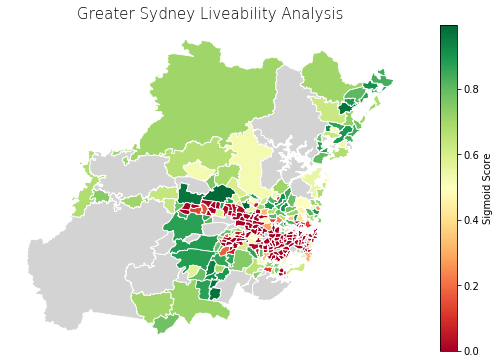

In [136]:
# MAIN CODE FOR TASK-2
sql="""
DROP TABLE IF EXISTS results;
CREATE TABLE results
AS

with Health AS 
(SELECT avg(1000.0*bs."health_care_and_social_assistance"/n."population") AS mean,
stddev(1000.0*bs."health_care_and_social_assistance"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Retail AS
(SELECT avg(1000.0*bs."retail_trade"/n."population") AS mean,
stddev(1000.0*bs."retail_trade"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Accom AS
(SELECT avg(1000.0*bs."accommodation_and_food_services"/n."population") AS mean,
stddev(1000.0*bs."accommodation_and_food_services"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Crime AS 
(SELECT AVG(q1) AS mean,
stddev(q1) AS sd
FROM ( SELECT AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")as q1
        FROM break_and_enter be join sa2_data s ON
        ST_Contains(s.geom,be.geom)
        GROUP BY s."SA2_NAME16") a ),
        
Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)

SELECT s."SA2_NAME16",

abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd) AS HZ,

abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd) AS RZ,

abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd) AS AZ,

abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)) AS CZ,

abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ,

1/(1+(exp(-((abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd))
            +(abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd))
            +(abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd))
            -(abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)))
            +(abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd))))))) AS Sigmoid

FROM sa2_data s, businessstats bs, break_and_enter be, neighbourhood n,school_catchments_combined sc, Health, Retail, Accom, crime, Schools
WHERE s."SA2_MAIN16" = bs."area_id"
AND bs."area_id" = n."area_id"
AND s."SA2_MAIN16" = n."area_id"
AND ST_Intersects(s.geom,be.geom)
AND ST_Intersects(s.geom,sc.geom)
GROUP BY s."SA2_NAME16"
ORDER BY sigmoid desc
;
"""
# Our Results
# results_df = query(conn,sql)
# results_df

# The common data between our result and sa2_data
# gdf = gpd.GeoDataFrame(results)
# gdf2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
# mg = gdf.reset_index().merge(gdf2, left_on = 'SA2_NAME16', right_on = 'SA2_NAME16') # Good
# mg 

# Greater Sydney Map
# gdf3 = gdf2[gdf2['GCC_NAME16']=='Greater Sydney'] 
# gdf3.plot(figsize=(10,6))
# gdf3

# Missing Rows Area
# df = pd.concat([mg.drop(columns=['index', 'hz','rz','az','cz','sz','sigmoid']), gdf3])
# gdf4 = df.drop_duplicates(keep=False)
# gdf4
# gdf4.plot()



# Correctly printing the Coloured Map
query(conn,sql)
results = query(conn,"SELECT * FROM results")
gdf = gpd.GeoDataFrame(results)
sa2_areas = gpd.read_file('SA2_2016_AUST/SA2_2016_AUST.shp')
merged = gdf.set_index('SA2_NAME16').join(sa2_areas.set_index('SA2_NAME16'))
# merged
gdf = gpd.GeoDataFrame(results)
merged2 = pd.concat([merged, gdf4], axis=0)
# merged2['geometry'] = merged2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
# merged2
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis', fontdict={'fontsize': '15', 'fontweight' : '3'})

merged2.plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "Sigmoid Score"},
            missing_kwds={"color": "lightgrey"})



In [ ]:
# Should be getting 312
# In total, getting 33 less rows
# Neighbourhood dataset has 13 less rows than sa2_data
# Break_and enter dataset has 28 less rows than sa2_data

sql = """
DROP TABLE IF EXISTS task3_data;
CREATE TABLE task3_data AS
select 
"hz", 
"rz", 
"az", 
"cz", 
"sz", 
"sigmoid",
"area_id",
"land_area",
"population",
"number_of_dwellings",
"number_of_businesses",
"median_annual_household_income",
"avg_monthly_rent",
"0-4",
"5-9",
"10-14",
"15-19",
"SA2_MAIN16",
s."SA2_NAME16",
"SA3_NAME16",
"AREASQKM16",
"geom"
from results R, neighbourhood N, sa2_data s
where s."SA2_MAIN16" = N."area_id"
and r."SA2_NAME16"=s."SA2_NAME16"
Order by sigmoid desc;
"""
query(conn,sql)
query(conn,"SELECT * FROM task3_data")
# results_table_combined=query(conn, sql)
# results_table_combined
# results_table_combined['sigmoid'].corr(results_table_combined['avg_monthly_rent']) # -0.03659452916437163
# results_table_combined['sigmoid'].corr(results_table_combined['median_annual_household_income']) # 0.05387892647209643

Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


/opt/jupyterhub/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


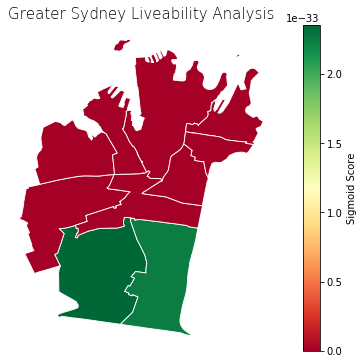

In [135]:
# TASK-3

# task3_database = merged2[merged2['SA3_NAME16']=='Sydney Inner City']
# task3_database

sql="""
DROP TABLE IF EXISTS Lights_database;
CREATE TABLE Lights_database AS

WITH Lights_data AS 
(SELECT avg(q1) AS mean,
stddev(q1) AS sd
FROM (SELECT COUNT(*) as q1 FROM
    task3_data t, lights l
    where "SA3_NAME16"='Sydney Inner City'
    AND ST_Contains(t.geom,l.geom)
    GROUP BY "SA2_NAME16" ) a)

SELECT t."SA2_NAME16",(abs(COUNT(*)-AVG(ld.mean))/AVG(ld.sd)) AS lz
FROM task3_data t, lights l, lights_data ld
where "SA3_NAME16"='Sydney Inner City'
AND ST_Contains(t.geom,l.geom)
GROUP BY "SA2_NAME16"
;
"""
query(conn,sql)
sql="""
DROP TABLE IF EXISTS Playgrounds_database;
CREATE TABLE Playgrounds_database AS

WITH Playgrounds_data AS 
(SELECT avg(q2) AS mean,
stddev(q2) AS sd
FROM (SELECT COUNT(*) as q2 FROM
    task3_data t, Playgrounds p
    where "SA3_NAME16"='Sydney Inner City'
    AND ST_Contains(t.geom,p.geom)
    GROUP BY "SA2_NAME16" ) a)

SELECT t."SA2_NAME16",(abs(COUNT(*)-AVG(pd.mean))/AVG(pd.sd)) AS pz
FROM task3_data t, playgrounds p, playgrounds_data pd
where "SA3_NAME16"='Sydney Inner City'
AND ST_Contains(t.geom,p.geom)
GROUP BY "SA2_NAME16"
;
"""
query(conn,sql)
# query(conn,"SELECT * FROM Playgrounds_database")
# query(conn,"SELECT * FROM Lights_database")

sql="""
DROP TABLE IF EXISTS task3_results;
CREATE TABLE task3_results AS

SELECT 
t."SA2_NAME16",
1/(1+(exp(-((hz)+(rz)+(az)-(cz)+(sz)+(lz)+(pz))))) AS Sigmoid,
t.geom

FROM 
task3_data t, lights_database l, playgrounds_database p
WHERE t."SA2_NAME16"=l."SA2_NAME16"
AND p."SA2_NAME16"=l."SA2_NAME16"
ORDER BY Sigmoid desc
"""

# Correctly printing the Coloured Map
query(conn,sql)
results_task3 = query(conn,"SELECT * FROM task3_results")
gdf_task3 = gpd.GeoDataFrame(results_task3)
# sa2_areas = gpd.read_file('SA2_2016_AUST/SA2_2016_AUST.shp')
merged_task3 = gdf_task3.set_index('SA2_NAME16').join(sa2_data_og.set_index('SA2_NAME16'))
merged_task3
# merged2 = pd.concat([merged, gdf4], axis=0)
# merged2
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis', fontdict={'fontsize': '15', 'fontweight' : '3'})

merged_task3.plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "Sigmoid Score"},
            missing_kwds={"color": "lightgrey"})

In [240]:
# df = pd.read_csv('CAvideos_stat.csv')
X = merged[['hz','az','cz','rz','sz']]      # slice dataFrame for input variables
y = merged['sigmoid']        # slice dataFrame for target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
regr = linear_model.LinearRegression().fit(X_train, y_train)

# # Let's create one sample and predict the number of comments
# sample = [1000, 100]        # a sample with 1000 likes and 100 dislikes
# sample_pred = regr.predict([sample])
# print('----- Sample case -----')
# print("likes:",sample[0])
# print("dislikes:",sample[1])
# print('Predicted number of comments:', int(sample_pred))
# print('-----------------------')

# The coefficients
print('Coefficients:')
print(regr.coef_)
# Use the model to predict y from X_test
y_pred = regr.predict(X_test)
# Root mean squared error
mse = metrics.mean_squared_error(y_test, y_pred)
print('Root mean squared error (RMSE):', sqrt(mse))
# R-squared score: 1 is perfect prediction
print('R-squared score:', metrics.r2_score(y_test, y_pred))

Coefficients:
[ 0.02037976  0.04182898 -0.00187523 -0.05240834  0.035309  ]
Root mean squared error (RMSE): 0.3439998283844413
R-squared score: -0.0012050160504588625


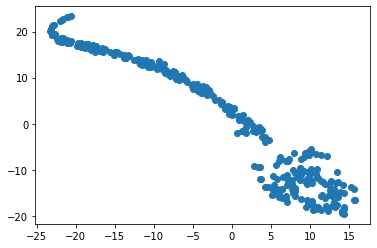

In [137]:
# Defining Model
model = TSNE(learning_rate=100)

# Fitting Model
transformed = model.fit_transform(merged[['hz','cz','az','cz','sz']])

# Plotting 2d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)
plt.show()

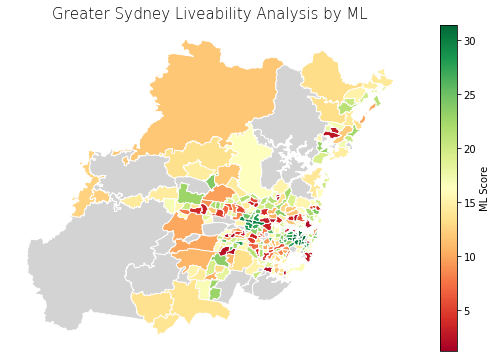

In [141]:
import math
data=[]
ML_merged=merged.copy()
for i in range(len(x_axis)) :
    new_row = math.sqrt(x_axis[i]**2 + y_axis[i]**2)
    data.append([new_row])

ML_df = pd.DataFrame(data,columns=['ML_Score'])
# ML_df
ML_merged = pd.concat([merged.reset_index(), ML_df], axis=1)
ML_merged = pd.concat([ML_merged, gdf4], axis=0)
# ML_merged

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis by ML', fontdict={'fontsize': '15', 'fontweight' : '3'})

ML_merged.plot(column='ML_Score',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "ML Score"},
            missing_kwds={"color": "lightgrey"})

In [101]:
conn.close()
db.dispose()

AttributeError: 'NoneType' object has no attribute 'close'

In [258]:
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loading dataset
iris_df = datasets.load_iris()
iris_df.target
# Defining Model
# model = TSNE(learning_rate=100)

# # Fitting Model
# transformed = model.fit_transform(iris_df.data)

# # Plotting 2d t-Sne
# x_axis = transformed[:, 0]
# y_axis = transformed[:, 1]

# plt.scatter(x_axis, y_axis, c=iris_df.target)
# plt.show()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])